In [169]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data Description

In [117]:
data = pd.read_csv("learning_mindset.csv")

In [118]:
data.shape

(10391, 13)

In [119]:
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


# Normal Linear Regression

In [120]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


In [121]:
data.query("intervention==1")["achievement_score"].mean() - data.query("intervention==0")["achievement_score"].mean()

0.4722716692516874

In [149]:
expect = data.groupby("success_expect")["intervention"].mean()

In [150]:
expect

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

<AxesSubplot:xlabel='success_expect'>

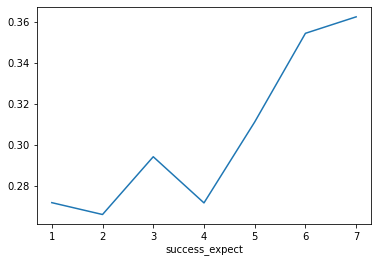

In [158]:
expect.plot()

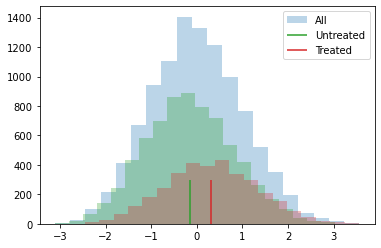

In [122]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")

plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

# Changing categorical features into dummies

In [172]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [173]:
data_with_categ.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,frst_in_family,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,...,ethnicity_13,ethnicity_14,ethnicity_15,gender_1,gender_2,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
259,73,1,1.480828,5,0,-0.462945,0.652608,-0.515202,-0.169849,0.173954,...,0,0,0,0,1,0,1,0,0,0
3435,76,0,-0.987277,5,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,1,0,0,1,0,0,0,0,0,1
9963,4,0,-0.152340,5,1,-2.289636,0.190797,0.875012,-0.724801,0.761781,...,0,0,0,0,1,1,0,0,0,0
4488,67,0,0.358336,6,0,-1.115337,1.053089,0.315755,0.054586,1.862187,...,0,1,0,1,0,0,0,0,0,1
2637,16,1,1.360920,6,0,-0.538975,1.433826,-0.033161,-0.982274,1.591641,...,0,0,0,1,0,0,1,0,0,0


# Propensity Score Estimation using Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315490
1,1,-0.449646,0.263803
2,1,0.769703,0.344039
3,1,-0.121763,0.344039
4,1,1.526147,0.367797


# Propensity score and success expect

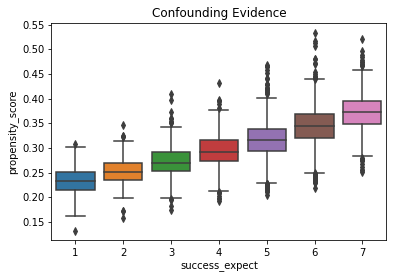

In [178]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)

plt.title("Confounding Evidence");

# Linear regression using PSM

In [128]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0768,0.065,-47.055,0.000,-3.205,-2.949
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0547,0.200,45.308,0.000,8.663,9.446


# Easier way to implement  Causal Effect

In [129]:
from causalinference import CausalModel

True Average Treatment Effect

In [130]:
confounders = data_with_categ.drop(columns=['achievement_score', 'intervention']).values

In [131]:
model = CausalModel(
    Y= data_ps["achievement_score"].values, 
    D = data_ps["intervention"].values,
    X= confounders
)

In [132]:
model.est_via_matching(matches=1, bias_adj=True)

print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.382      0.023     16.327      0.000      0.336      0.428
           ATC      0.368      0.025     14.540      0.000      0.318      0.417
           ATT      0.412      0.025     16.206      0.000      0.362      0.462



Estimated Average Treatment Effect using PSM

In [133]:
model2 = CausalModel(
    Y= data_ps["achievement_score"].values, 
    D = data_ps["intervention"].values,
    X= data_ps["propensity_score"].values
)

In [134]:
model2.est_via_matching(matches=1, bias_adj=True)

print(model2.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.392      0.025     15.696      0.000      0.343      0.442
           ATC      0.385      0.027     14.031      0.000      0.331      0.439
           ATT      0.407      0.027     15.315      0.000      0.355      0.460

